### For single power of 975 nm and 1064 nm

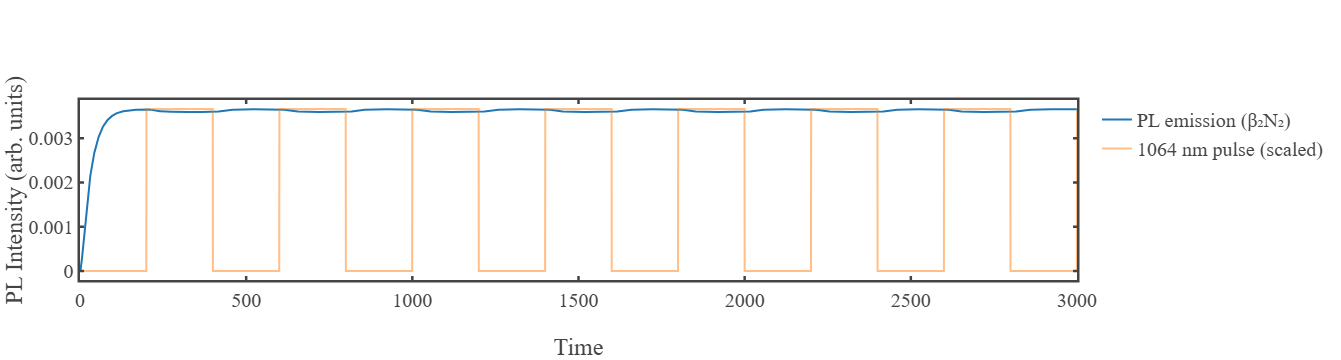

PL at pulse start (avg): 3.656781e-03
PL at pulse end   (avg): 3.590793e-03
Quenching during 4th pulse: 1.80 %


In [12]:
import numpy as np
from scipy.integrate import solve_ivp
import plotly.graph_objects as go

# ------------------------------------------------------------
# --- Simulation parameters ---
# ------------------------------------------------------------
t_max = 3000.0       # total simulation time
dt = 0.5             # time step
t_eval = np.linspace(0, t_max, int(t_max/dt)+1)

# Pulse parameters
laser_on = 200.0
laser_off = 200.0
period = laser_on + laser_off
phase_shift = laser_on  # phase offset for 1064 pulse

# Lifetimes
beta1 = 0.01
beta2 = 0.03

# Coefficients
k_alpha1  = 2
k_alpha1p = 0.05
k_alpha2  = 0.07
k_alpha2p = 0.0001
k_gamma_975 = 0.00001
k_gamma_1064 = 0.017

# Plotly template
fig_template = go.layout.Template()
fig_template.layout = {
    'template': 'simple_white+presentation',
    'autosize': False,
    'width': 1000,
    'height': 450,
    'xaxis': {'ticks':'inside','mirror':'ticks','linewidth':2.5,'tickwidth':2.5,'ticklen':4,'showline':True,'showgrid':False, 'zeroline':False},
    'yaxis': {'ticks':'inside','mirror':'ticks','linewidth':2.5,'tickwidth':2.5,'ticklen':4,'showline':True,'showgrid':False, 'zeroline':False},
    'font': {'family':'mathjax','size':20}
}

# ------------------------------------------------------------
# --- 1064 nm pulse function ---
# ------------------------------------------------------------
def make_I1064_func(I_1064_peak):
    def I1064(t):
        phase = np.mod(t + phase_shift, period)
        return np.where(phase < laser_on, I_1064_peak, 0.0)
    return I1064

# ------------------------------------------------------------
# --- Run simulation for chosen powers ---
# ------------------------------------------------------------
def run_sim_with_trace(I_975, I_1064_peak):
    I1064 = make_I1064_func(I_1064_peak)

    def I975_func(t):
        return I_975 if np.isscalar(t) else np.full_like(t, I_975)

    def alpha1(t):  return k_alpha1 * I975_func(t) + k_alpha2 * I1064(t)
    def alpha1p(t): return k_alpha1p * I975_func(t) + k_alpha2p * I1064(t)
    def gamma975(t):  return k_gamma_975 * I975_func(t)
    def gamma1064(t): return k_gamma_1064 * I1064(t)

    def rate_equations(t, N):
        N0, N1, N2 = N
        a1  = alpha1(t)
        a1p = alpha1p(t)
        g1  = gamma975(t)
        g2  = gamma1064(t)
        dN0 = -a1*N0 + (beta1+g1+g2)*N1 + beta2*N2
        dN1 = a1*N0 - (a1p+beta1+g1+g2)*N1
        dN2 = a1p*N1 - beta2*N2
        return [dN0, dN1, dN2]

    # Solve ODEs
    sol = solve_ivp(rate_equations, [0, t_max], [1, 0, 0],
                    t_eval=t_eval, atol=1e-9, rtol=1e-7)

    t = sol.t
    N2 = sol.y[2]
    emission = beta2 * N2

    I1064_trace = np.array([I1064(ti) for ti in t])

    return t, emission, I1064_trace

# ------------------------------------------------------------
# --- Manual powers to match experiment ---
# ------------------------------------------------------------
I975_chosen  = 0.09
I1064_chosen = 1.2

PL_t, PL_em, I1064_t = run_sim_with_trace(I975_chosen, I1064_chosen)

# ------------------------------------------------------------
# --- Normalize 1064 nm pulse for visual overlay ---
# ------------------------------------------------------------
I1064_norm = I1064_t / I1064_t.max() * PL_em.max()

# ------------------------------------------------------------
# --- Plot PL + 1064 nm pulse ---
# ------------------------------------------------------------
fig_time = go.Figure()

fig_time.add_trace(go.Scatter(
    x=PL_t, y=PL_em, mode="lines", name="PL emission (β₂N₂)"
))
fig_time.add_trace(go.Scatter(
    x=PL_t, y=I1064_norm, mode="lines", name="1064 nm pulse (scaled)", opacity=0.5
))

fig_time.update_layout(
    template=fig_template,
    xaxis_title="Time",
    yaxis_title="PL Intensity (arb. units)"
)
fig_time.show()

# ------------------------------------------------------------
# --- Pulse-edge quenching with small dt window ---
# ------------------------------------------------------------
pulse_index = 4
dt_sample = dt  # small averaging window

# Detect rising edges of 1064 nm pulse
on_indices = np.where((I1064_t[:-1] == 0) & (I1064_t[1:] > 0))[0]
if pulse_index >= len(on_indices):
    raise ValueError("Not enough pulses in the simulation.")

idx_on = on_indices[pulse_index] + 1

# Detect falling edge of the same pulse
off_candidates = np.where(I1064_t[idx_on:] == 0)[0]
idx_off = idx_on + off_candidates[0]

# Define small dt windows around pulse edges
start_mask = (PL_t >= PL_t[idx_on]) & (PL_t < PL_t[idx_on] + dt_sample)
end_mask   = (PL_t >= PL_t[idx_off] - dt_sample) & (PL_t < PL_t[idx_off])

PL_start = PL_em[start_mask].mean()
PL_end   = PL_em[end_mask].mean()

quench_4th = (PL_start - PL_end) / PL_start * 100

print(f"PL at pulse start (avg): {PL_start:.6e}")
print(f"PL at pulse end   (avg): {PL_end:.6e}")
print(f"Quenching during 4th pulse: {quench_4th:.2f} %")

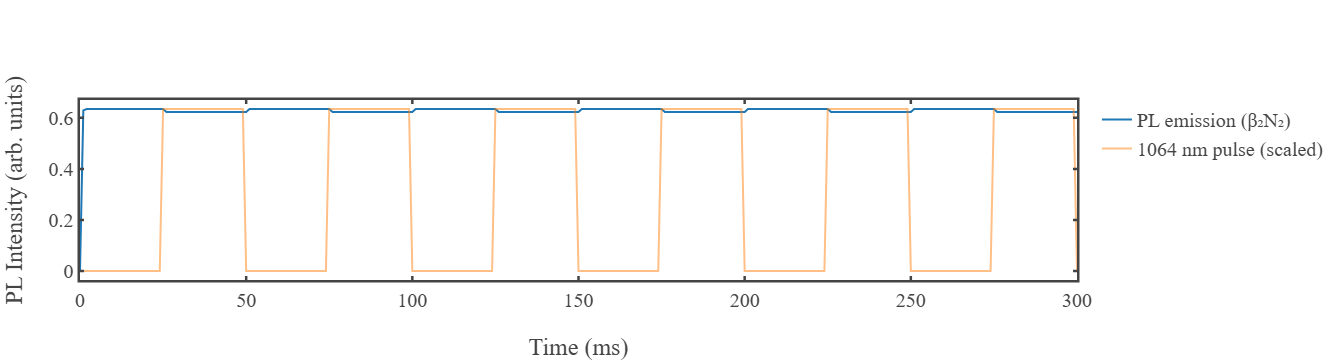

PL at pulse start (avg): 6.347022e-01
PL at pulse end   (avg): 6.231372e-01
Quenching during 4th pulse: 1.82 %


In [13]:
import numpy as np
from scipy.integrate import solve_ivp
import plotly.graph_objects as go

# ------------------------------------------------------------
# --- Simulation parameters ---
# ------------------------------------------------------------
t_max = 300.0       # total simulation time in ms (enough to cover several pulses)
dt = 1.0            # time step in ms
t_eval = np.arange(0, t_max+dt, dt)

# Pulse parameters (ms)
laser_on = 25.0
laser_off = 25.0
period = laser_on + laser_off
phase_shift = laser_on  # phase offset for 1064 pulse

# Lifetimes (ms)
beta1 = 1/0.5   # generally longer as seen in the excited state of Yb3+
beta2 = 1/0.25  # effective lifetime from both 975 nm and 1064 nm wavelengths

# Coefficients (1/ms/mW)
# Chosen roughly to reproduce ~2% quenching for given powers
k_alpha1  = 5  # 975 nm excitation
k_alpha1p = 0.04
k_alpha2  = 0.06  # 1064 nm weak contribution
k_alpha2p = 0.0005
k_gamma_975 = 0.00001
k_gamma_1064 = 0.1

# # Lifetimes
# beta1 = 0.01
# beta2 = 0.03

# # Coefficients
# k_alpha1  = 2
# k_alpha1p = 0.05
# k_alpha2  = 0.07
# k_alpha2p = 0.0001
# k_gamma_975 = 0.00001
# k_gamma_1064 = 0.017

# Plotly template
fig_template = go.layout.Template()
fig_template.layout = {
    'template': 'simple_white+presentation',
    'autosize': False,
    'width': 1000,
    'height': 450,
    'xaxis': {'ticks':'inside','mirror':'ticks','linewidth':2.5,'tickwidth':2.5,'ticklen':4,'showline':True,'showgrid':False, 'zeroline':False},
    'yaxis': {'ticks':'inside','mirror':'ticks','linewidth':2.5,'tickwidth':2.5,'ticklen':4,'showline':True,'showgrid':False, 'zeroline':False},
    'font': {'family':'mathjax','size':20}
}

# ------------------------------------------------------------
# --- 1064 nm pulse function ---
# ------------------------------------------------------------
def make_I1064_func(I_1064_peak):
    def I1064(t):
        phase = np.mod(t + phase_shift, period)
        return np.where(phase < laser_on, I_1064_peak, 0.0)
    return I1064

# ------------------------------------------------------------
# --- Run simulation for chosen powers ---
# ------------------------------------------------------------
def run_sim_with_trace(I_975, I_1064_peak):
    I1064 = make_I1064_func(I_1064_peak)

    def I975_func(t):
        return I_975 if np.isscalar(t) else np.full_like(t, I_975)

    def alpha1(t):  return k_alpha1 * I975_func(t) + k_alpha2 * I1064(t)
    def alpha1p(t): return k_alpha1p * I975_func(t) + k_alpha2p * I1064(t)
    def gamma975(t):  return k_gamma_975 * I975_func(t)
    def gamma1064(t): return k_gamma_1064 * I1064(t)

    def rate_equations(t, N):
        N0, N1, N2 = N
        a1  = alpha1(t)
        a1p = alpha1p(t)
        g1  = gamma975(t)
        g2  = gamma1064(t)
        dN0 = -a1*N0 + (beta1+g1+g2)*N1 + beta2*N2
        dN1 = a1*N0 - (a1p+beta1+g1+g2)*N1
        dN2 = a1p*N1 - beta2*N2
        return [dN0, dN1, dN2]

    sol = solve_ivp(rate_equations, [0, t_max], [1,0,0],
                    t_eval=t_eval, atol=1e-9, rtol=1e-7)

    t = sol.t
    N2 = sol.y[2]
    emission = beta2 * N2

    I1064_trace = np.array([I1064(ti) for ti in t])
    return t, emission, I1064_trace

# ------------------------------------------------------------
# --- Manual powers in mW to match experiment ---
# ------------------------------------------------------------
I975_chosen  = 19.4
I1064_chosen = 77.0

PL_t, PL_em, I1064_t = run_sim_with_trace(I975_chosen, I1064_chosen)

# ------------------------------------------------------------
# --- Normalize 1064 nm pulse for visual overlay ---
# ------------------------------------------------------------
I1064_norm = I1064_t / I1064_t.max() * PL_em.max()

# ------------------------------------------------------------
# --- Plot PL + 1064 nm pulse ---
# ------------------------------------------------------------
fig_time = go.Figure()
fig_time.add_trace(go.Scatter(x=PL_t, y=PL_em, mode="lines", name="PL emission (β₂N₂)"))
fig_time.add_trace(go.Scatter(x=PL_t, y=I1064_norm, mode="lines", name="1064 nm pulse (scaled)", opacity=0.5))
fig_time.update_layout(template=fig_template, xaxis_title="Time (ms)", yaxis_title="PL Intensity (arb. units)")
fig_time.show()

# ------------------------------------------------------------
# --- Pulse-edge quenching with dt window ---
# ------------------------------------------------------------
pulse_index = 4
dt_sample = dt  # averaging window = 1 ms

# Detect rising edges of 1064 nm pulse
on_indices = np.where((I1064_t[:-1] == 0) & (I1064_t[1:] > 0))[0]
if pulse_index >= len(on_indices):
    raise ValueError("Not enough pulses in the simulation.")

idx_on = on_indices[pulse_index] + 1

# Detect falling edge of the same pulse
off_candidates = np.where(I1064_t[idx_on:] == 0)[0]
idx_off = idx_on + off_candidates[0]

# Small windows around edges
start_mask = (PL_t >= PL_t[idx_on]) & (PL_t < PL_t[idx_on] + dt_sample)
end_mask   = (PL_t >= PL_t[idx_off] - dt_sample) & (PL_t < PL_t[idx_off])

PL_start = PL_em[start_mask].mean()
PL_end   = PL_em[end_mask].mean()

quench_4th = (PL_start - PL_end) / PL_start * 100

print(f"PL at pulse start (avg): {PL_start:.6e}")
print(f"PL at pulse end   (avg): {PL_end:.6e}")
print(f"Quenching during 4th pulse: {quench_4th:.2f} %")

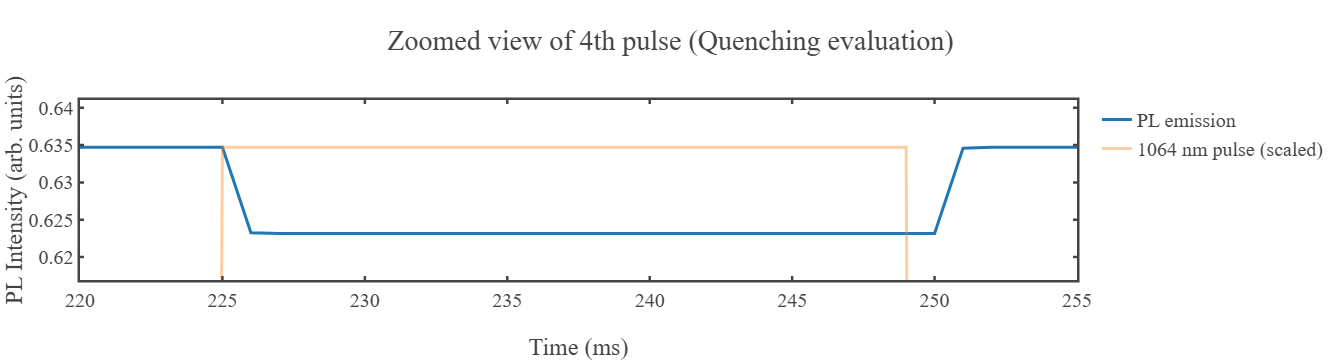

In [15]:
# ------------------------------------------------------------
# --- Zoomed plot around the 4th pulse (quenching visualization)
# ------------------------------------------------------------

# Time window for zoom (a bit before ON and after OFF)
t_zoom_start = PL_t[idx_on]  - 5*dt
t_zoom_end   = PL_t[idx_off] + 5*dt

zoom_mask = (PL_t >= t_zoom_start) & (PL_t <= t_zoom_end)

# --- Y-axis limits: ±1% around quenching ---
y_max = PL_start * 1.01   # 1% above PL at pulse start
y_min = PL_end   * 0.99   # 1% below PL at pulse end

fig_zoom = go.Figure()

# PL emission (zoomed)
fig_zoom.add_trace(go.Scatter(
    x=PL_t[zoom_mask],
    y=PL_em[zoom_mask],
    mode="lines",
    name="PL emission",
    line=dict(width=3)
))

# 1064 nm pulse (scaled, zoomed)
fig_zoom.add_trace(go.Scatter(
    x=PL_t[zoom_mask],
    y=I1064_norm[zoom_mask],
    mode="lines",
    name="1064 nm pulse (scaled)",
    opacity=0.4,
    line=dict(width=3)
))


fig_zoom.update_layout(
    template=fig_template,
    title="Zoomed view of 4th pulse (Quenching evaluation)",
    xaxis_title="Time (ms)",
    yaxis_title="PL Intensity (arb. units)",
    yaxis=dict(
        range=[y_min, y_max],
        zeroline=False
    )
)

fig_zoom.show()


### Building quenching matrix

In [17]:
import numpy as np
from scipy.integrate import solve_ivp
from joblib import Parallel, delayed
from tqdm import tqdm
from contextlib import contextmanager

# --- Joblib + tqdm helper ---
@contextmanager
def tqdm_joblib(tqdm_object):
    import joblib
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)
    old_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_callback
        tqdm_object.close()

# --- Time grid ---
t_max = 3000.0
dt = 0.5
t_eval = np.linspace(0, t_max, int(t_max/dt)+1)

# --- Pulse parameters ---
laser_on = 200.0
laser_off = 200.0
period = laser_on + laser_off
phase_shift = laser_on

def make_I1064_func(I_1064_peak):
    def I1064(t):
        phase = np.mod(t + phase_shift, period)
        return np.where(phase < laser_on, I_1064_peak, 0.0)
    return I1064

# --- Lifetimes ---
beta1 = 1/5.0
beta2 = 1/100.0

# --- Coefficients ---
k_alpha1 = 0.1
k_alpha1p = 0.1
k_alpha2 = 0.001
k_alpha2p = 0.001
k_gamma_975 = 0.001
k_gamma_1064 = 0.2

# --- Simulation function ---
def run_sim(I_975, I_1064_peak):
    I1064 = make_I1064_func(I_1064_peak)
    def I975_func(t):
        return I_975 if np.isscalar(t) else np.full_like(t, I_975)

    def alpha1(t):  return k_alpha1 * I975_func(t) + k_alpha2 * I1064(t)
    def alpha1p(t): return k_alpha1p * I975_func(t) + k_alpha2p * I1064(t)
    def gamma975(t):  return k_gamma_975 * I975_func(t)
    def gamma1064(t): return k_gamma_1064 * I1064(t)

    def rate_equations(t, N):
        N0, N1, N2 = N
        a1  = alpha1(t)
        a1p = alpha1p(t)
        g1  = gamma975(t)
        g2  = gamma1064(t)
        dN0 = -a1*N0 + (beta1+g1+g2)*N1 + beta2*N2
        dN1 = a1*N0 - (a1p+beta1+g1+g2)*N1
        dN2 = a1p*N1 - beta2*N2
        return [dN0, dN1, dN2]

    sol = solve_ivp(rate_equations, [0, t_max], [1,0,0],
                    t_eval=t_eval, atol=1e-9, rtol=1e-7)
    t = sol.t
    N2 = sol.y[2]
    emission = beta2 * N2

    steady_cut = 5 * period
    mask = t >= steady_cut
    phase = np.mod(t + phase_shift, period)
    off_mask = mask & (phase >= laser_on)
    on_mask  = mask & (phase < laser_on)

    if off_mask.sum() == 0 or on_mask.sum() == 0:
        return np.nan

    mean_off = emission[off_mask].mean()
    mean_on  = emission[on_mask].mean()
    quench = (mean_off - mean_on)/mean_off*100
    return quench

# --- Power grids ---
powers_975  = np.geomspace(0.01, 2, 10)
powers_1064 = np.geomspace(0.01, 1.7, 10)

N1 = len(powers_975)
N2 = len(powers_1064)

Q = np.zeros((N2, N1))

# --- Parallel 2D simulation ---
tasks = [(i, j, p975, p1064)
         for j, p1064 in enumerate(powers_1064)
         for i, p975 in enumerate(powers_975)]

with tqdm_joblib(tqdm(total=len(tasks), desc="Computing 2D Quenching Matrix")):
    results = Parallel(n_jobs=-1)(
        delayed(lambda x: (x[0], x[1], run_sim(x[2], x[3])))(task)
        for task in tasks
    )

for i, j, q in results:
    Q[j, i] = q

Computing 2D Quenching Matrix: 100%|██████████| 100/100 [00:10<00:00,  9.32it/s]


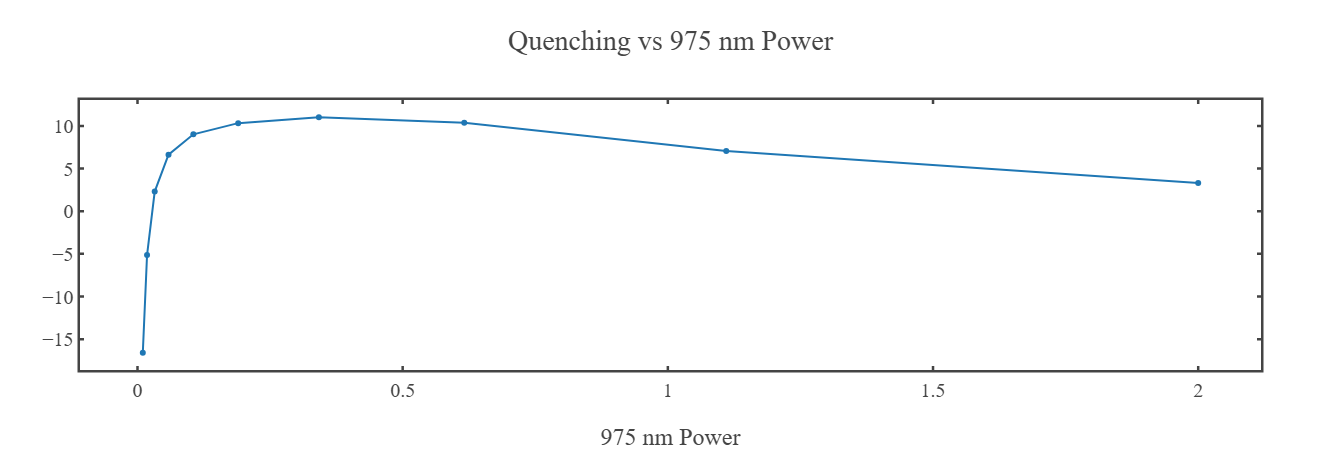

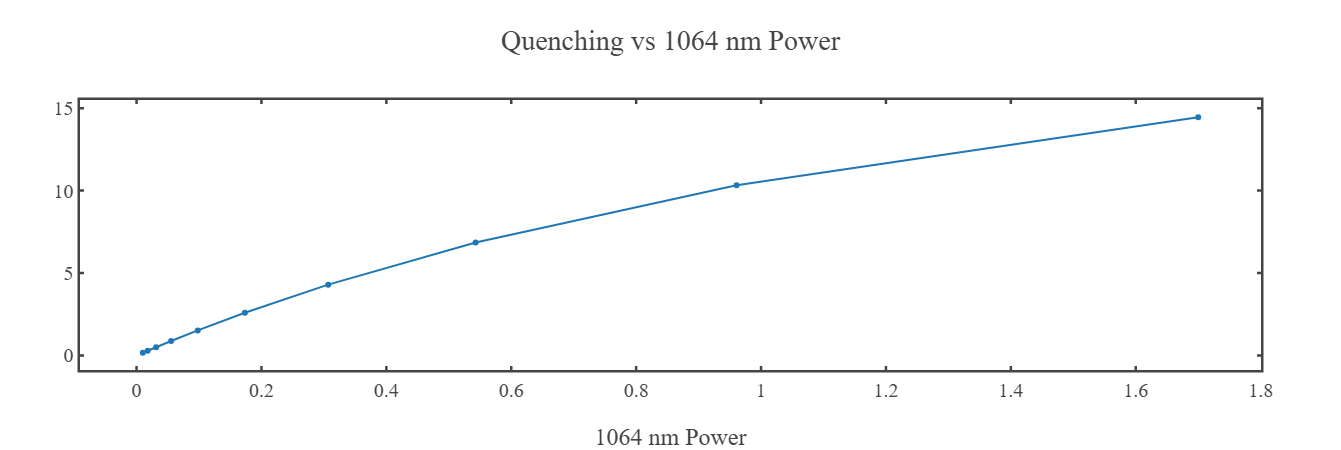

In [18]:
import plotly.graph_objects as go
import numpy as np

# ------------------------------------------------------------
# Choose fixed powers (nearest indices from grids)
# ------------------------------------------------------------
I975_fixed  = 0.2
I1064_fixed = 0.9

idx_975  = np.argmin(np.abs(powers_975  - I975_fixed))
idx_1064 = np.argmin(np.abs(powers_1064 - I1064_fixed))

# ------------------------------------------------------------
# 1) Quenching vs 975 nm power (fixed 1064 nm)
# ------------------------------------------------------------
fig_q_975 = go.Figure()

fig_q_975.add_trace(
    go.Scatter(
        x=powers_975,
        y=Q[idx_1064, :],
        mode="lines+markers",
        name=f"1064 nm = {powers_1064[idx_1064]:.2f}"
    )
)

fig_q_975.update_layout(
    template=fig_template,
    width = 800,
    height = 450,
    xaxis_title="975 nm Power",
    # yaxis_title="Quenching (%)",
    title="Quenching vs 975 nm Power",
        xaxis=dict(
        zeroline=False,   # remove x=0 line
        showline=True
    ),
    yaxis=dict(
        zeroline=False,   # remove y=0 line
        showline=True
    )
)

fig_q_975.show()

# ------------------------------------------------------------
# 2) Quenching vs 1064 nm power (fixed 975 nm)
# ------------------------------------------------------------
fig_q_1064 = go.Figure()

fig_q_1064.add_trace(
    go.Scatter(
        x=powers_1064,
        y=Q[:, idx_975],
        mode="lines+markers",
        name=f"975 nm = {powers_975[idx_975]:.2f}"
    )
)

fig_q_1064.update_layout(
    template=fig_template,
    width = 800,
    height = 450,
    xaxis_title="1064 nm Power",
    # yaxis_title="Quenching (%)",
    title="Quenching vs 1064 nm Power",
        xaxis=dict(
        zeroline=False,   # remove x=0 line
        showline=True
    ),
    yaxis=dict(
        zeroline=False,   # remove y=0 line
        showline=True
    )
)


fig_q_1064.show()

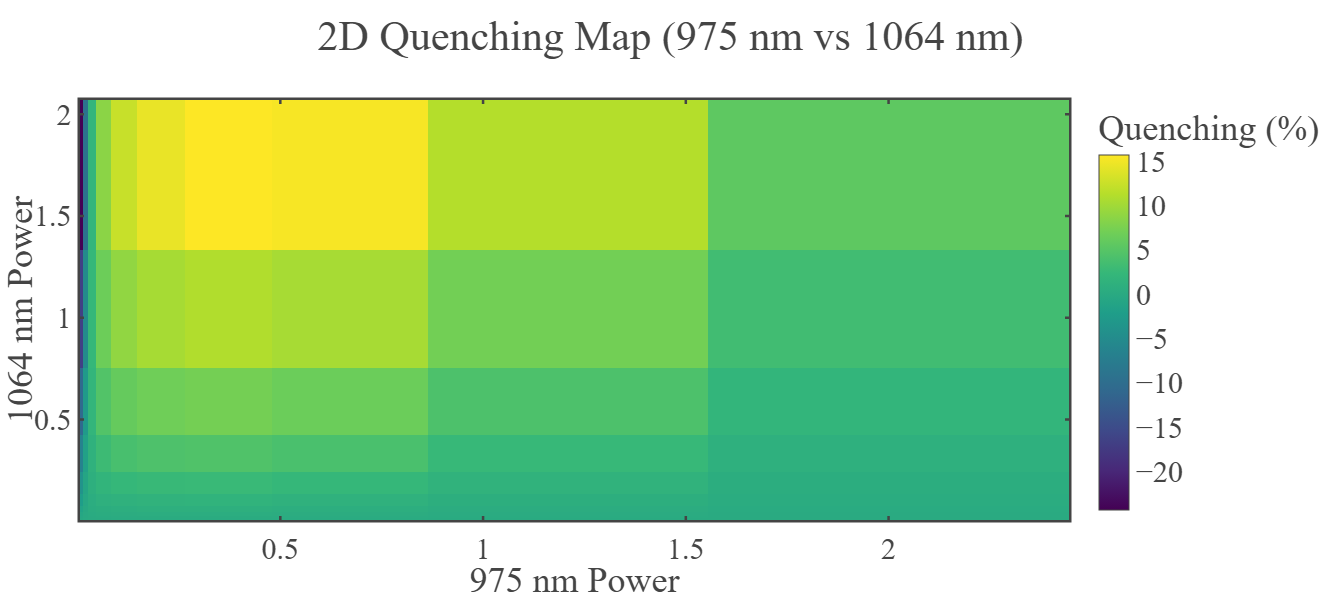

In [19]:
import plotly.graph_objects as go

# ============================================================
# --- Figure template ---
# ============================================================
fig_template = go.layout.Template()
fig_template.layout = {
    'template': 'simple_white+presentation',
    'autosize': False,
    'width': 800,
    'height': 600,
    'xaxis': {'ticks':'inside','mirror':'ticks','linewidth':2.5,'tickwidth':2.5,'ticklen':4,'showline':True,'showgrid':False},
    'yaxis': {'ticks':'inside','mirror':'ticks','linewidth':2.5,'tickwidth':2.5,'ticklen':4,'showline':True,'showgrid':False},
    'font': {'family':'mathjax','size':30}
}

# ============================================================
# --- PLOT 1: Heatmap ---
# ============================================================
fig_hm = go.Figure(data=go.Heatmap(
    x=powers_975,
    y=powers_1064,
    z=Q,
    colorscale="Viridis",
    colorbar_title="Quenching (%)"
))
fig_hm.update_layout(
    template=fig_template,
    width = 1000,
    height = 600,
    title="2D Quenching Map (975 nm vs 1064 nm)",
    xaxis_title="975 nm Power",
    yaxis_title="1064 nm Power"
)
fig_hm.show()

Computing Quenching Matrix: 100%|██████████| 25/25 [00:47<00:00,  1.89s/it]


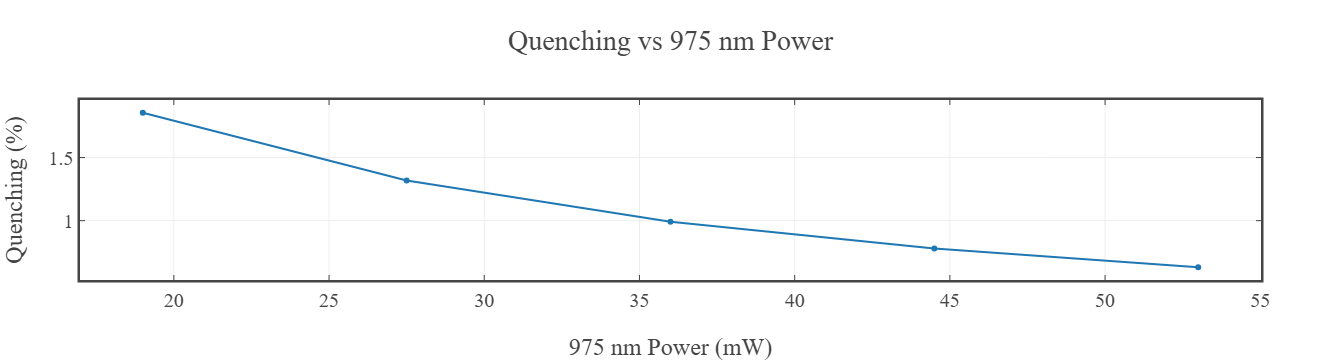

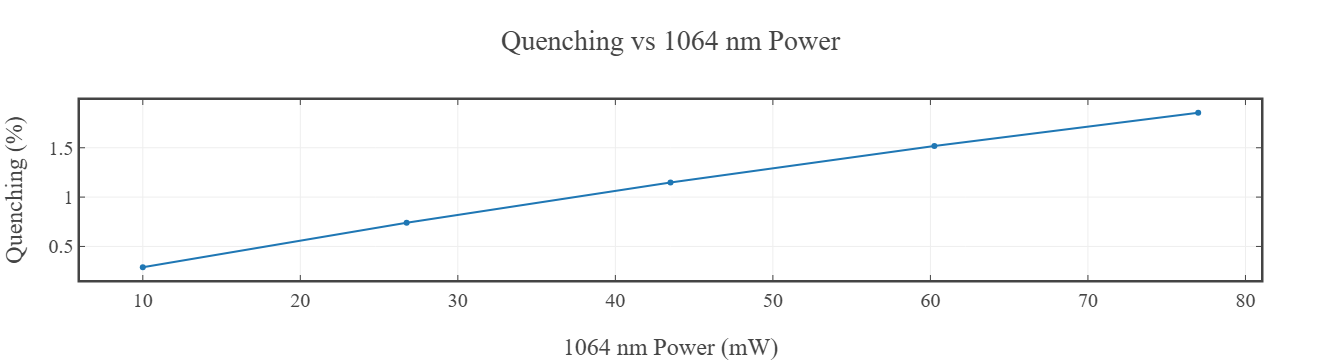

In [21]:
import numpy as np
from scipy.integrate import solve_ivp
from joblib import Parallel, delayed
from tqdm import tqdm
from contextlib import contextmanager
import plotly.graph_objects as go

# ============================================================
# --- Joblib + tqdm helper (same as first code)
# ============================================================
@contextmanager
def tqdm_joblib(tqdm_object):
    import joblib
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)
    old_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_callback
        tqdm_object.close()

# ============================================================
# --- Simulation parameters
# ============================================================
t_max = 300.0
dt = 1.0
t_eval = np.arange(0, t_max + dt, dt)

laser_on = 25.0
laser_off = 25.0
period = laser_on + laser_off
phase_shift = laser_on

# Lifetimes (ms)
beta1 = 1/0.5
beta2 = 1/0.25

# Coefficients
k_alpha1  = 5
k_alpha1p = 0.04
k_alpha2  = 0.06
k_alpha2p = 0.0005
k_gamma_975  = 0.00001
k_gamma_1064 = 0.1

# ============================================================
# --- Plotly template
# ============================================================
fig_template = go.layout.Template()
fig_template.layout = {
    'template': 'simple_white+presentation',
    'autosize': False,
    'width': 800,
    'height': 450,
    'xaxis': {'ticks':'inside','mirror':'ticks','linewidth':2.5,'showline':True,'zeroline':False},
    'yaxis': {'ticks':'inside','mirror':'ticks','linewidth':2.5,'showline':True,'zeroline':False},
    'font': {'family':'mathjax','size':20}
}

# ============================================================
# --- 1064 nm pulse
# ============================================================
def make_I1064_func(I_1064_peak):
    def I1064(t):
        phase = np.mod(t + phase_shift, period)
        return np.where(phase < laser_on, I_1064_peak, 0.0)
    return I1064

# ============================================================
# --- Single simulation → quenching
# ============================================================
def run_sim_quench(I_975, I_1064_peak, pulse_index=4):
    I1064 = make_I1064_func(I_1064_peak)

    def I975_func(t):
        return I_975 if np.isscalar(t) else np.full_like(t, I_975)

    def alpha1(t):  return k_alpha1 * I975_func(t) + k_alpha2 * I1064(t)
    def alpha1p(t): return k_alpha1p * I975_func(t) + k_alpha2p * I1064(t)
    def gamma975(t):  return k_gamma_975 * I975_func(t)
    def gamma1064(t): return k_gamma_1064 * I1064(t)

    def rate_equations(t, N):
        N0, N1, N2 = N
        a1  = alpha1(t)
        a1p = alpha1p(t)
        g1  = gamma975(t)
        g2  = gamma1064(t)
        dN0 = -a1*N0 + (beta1+g1+g2)*N1 + beta2*N2
        dN1 = a1*N0 - (a1p+beta1+g1+g2)*N1
        dN2 = a1p*N1 - beta2*N2
        return [dN0, dN1, dN2]

    sol = solve_ivp(rate_equations, [0, t_max], [1,0,0],
                    t_eval=t_eval, atol=1e-9, rtol=1e-7)

    t = sol.t
    emission = beta2 * sol.y[2]
    I1064_t = np.array([I1064(ti) for ti in t])

    # Detect rising edges
    on_indices = np.where((I1064_t[:-1] == 0) & (I1064_t[1:] > 0))[0]
    if pulse_index >= len(on_indices):
        return np.nan

    idx_on = on_indices[pulse_index] + 1
    idx_off = idx_on + np.where(I1064_t[idx_on:] == 0)[0][0]

    start_mask = (t >= t[idx_on]) & (t < t[idx_on] + dt)
    end_mask   = (t >= t[idx_off] - dt) & (t < t[idx_off])

    PL_start = emission[start_mask].mean()
    PL_end   = emission[end_mask].mean()

    return (PL_start - PL_end) / PL_start * 100

# ============================================================
# --- Power grids (EXPERIMENTAL)
# ============================================================
powers_975  = np.linspace(19.0, 53.0, 5)
powers_1064 = np.linspace(10.0, 77.0, 5)

N1 = len(powers_975)
N2 = len(powers_1064)

Q = np.zeros((N2, N1))

# ============================================================
# --- Parallel computation
# ============================================================
tasks = [(i, j, p975, p1064)
         for j, p1064 in enumerate(powers_1064)
         for i, p975 in enumerate(powers_975)]

with tqdm_joblib(tqdm(total=len(tasks), desc="Computing Quenching Matrix")):
    results = Parallel(n_jobs=-1)(
        delayed(lambda x: (x[0], x[1], run_sim_quench(x[2], x[3])))(task)
        for task in tasks
    )

for i, j, q in results:
    Q[j, i] = q

# ============================================================
# --- Plot 1: Quenching vs 975 nm (fixed 1064)
# ============================================================
I1064_fixed = 77.0
idx_1064 = np.argmin(np.abs(powers_1064 - I1064_fixed))

fig_q_975 = go.Figure()
fig_q_975.add_trace(go.Scatter(
    x=powers_975,
    y=Q[idx_1064, :],
    mode="lines+markers",
    name=f"1064 nm = {powers_1064[idx_1064]:.1f} mW"
))
fig_q_975.update_layout(
    template=fig_template,
    xaxis_title="975 nm Power (mW)",
    yaxis_title="Quenching (%)",
    title="Quenching vs 975 nm Power"
)
fig_q_975.show()

# ============================================================
# --- Plot 2: Quenching vs 1064 nm (fixed 975)
# ============================================================
I975_fixed = 19.4
idx_975 = np.argmin(np.abs(powers_975 - I975_fixed))

fig_q_1064 = go.Figure()
fig_q_1064.add_trace(go.Scatter(
    x=powers_1064,
    y=Q[:, idx_975],
    mode="lines+markers",
    name=f"975 nm = {powers_975[idx_975]:.1f} mW"
))
fig_q_1064.update_layout(
    template=fig_template,
    xaxis_title="1064 nm Power (mW)",
    yaxis_title="Quenching (%)",
    title="Quenching vs 1064 nm Power"
)
fig_q_1064.show()


### Observations 

1. With fixed **high** 975 nm power, the quenching percentage is **increasing** with the power of the 1064 nm wavelength.
2. With fixed **low** 975 nm power, the quenching percentage is **decreasing** with the power of the 1064 nm wavelength.
3. With fixed **low** or **high** power of 1064 nm wavelength, the nature of the quenching percentage curve with 975 nm powers is **unchanged**, except that the PL enhancement is increasing with the increment of 1064 nm power.

4. The PL emission is controllable with the varied 975 nm powers, either increasing or decreasing, similar to the experimental observation.